## Unsupervised Behavioral Phenotyping with 3D Skeletal Pose
Joshua Wu
Duke University Biomedical Engineering
Timothy Dunn Lab

25 July, 2023

Neurodegenerative diseases (like Parkinson's) are characterized by a wide variety of behavioral defects or movement deficits. However, behavior and movement have historically been difficult to quantify and measure. Recent developments in hardware and machine learning have enabled more objective behavioral metrics by providing continuous 3D measurements of naturalistic animal behavior through multi-view videos. These new modalities of data offer a means by which we can comprehensively characterize behavioral phenotypes of neural (dys)-function. We present `dappy` to establish an open-source API with easy access to machine learning methods for the analysis of 3D pose sequences.

This notebook implements a Python version of [CAPTURE (Marshall, 2020)](https://www.cell.com/neuron/fulltext/S0896-6273(20)30894-1?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627320308941%3Fshowall%3Dtrue), which was based on earlier work [MotionMapper (Berman, 2014)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2014.0672) for the analysis of behavioral data.

To get this notebook to run, please download the [demo dataset](https://duke.box.com/v/demo-mouse-poses) into the `/dappy/data/` directory.

First, we import the necessary modules.

In [26]:
from dappy import read, write
from dappy import visualization as vis
import numpy as np
import time
from IPython.display import Video
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

Load pose predictions, keypoint connectivity information, and metadata.

In [5]:
analysis_key = "tutorial"
config = read.config("../configs/" + analysis_key + ".yaml")

pose, ids = read.pose_h5(config["data_path"] + "demo_mouse.h5")

connectivity = read.connectivity(
    path=config["skeleton_path"], skeleton_name=config["skeleton_name"]
)

meta, meta_by_frame = read.meta(config["data_path"] + "demo_meta.csv", id=ids)

Path(config["out_path"]).mkdir(parents=True, exist_ok=True)

`pose` shape (# frames x # keypoints x 3 coordinates).

In [7]:
print("Pose shape (# frames x # keypoints x 3 coordinates): ")
print(pose.shape)

Pose shape (# frames x # keypoints x 3 coordinates): 
(648000, 18, 3)


`meta` contains categorical information on recording sessions in `pose`. Here, we have loaded in two sessions. Each frame of the `pose` has a session id label in `ids`.

In [15]:
print(meta)
print("\n" + str(ids))

   id AnimalID     Sex       Strain Condition
0   0       A0    Male  Adora2a-Cre  Baseline
1   1       A1  Female  Adora2a-Cre  Baseline

[0 0 0 ... 1 1 1]


`connectivity` contains key information indicating keypoint labels, connectivity, etc.

In [16]:
print("keypoint labels")
print(connectivity.joint_names)
print("\n Keypoint connections")
print(connectivity.links)

keypoint labels
['Snout', 'EarR', 'EarL', 'SpineF', 'SpineM', 'Tail_base_', 'Forepaw_R', 'Wrist_R', 'ForeLimb_R', 'Forepaw_L', 'Wrist_L', 'Forelimb_L', 'Hindpaw_R', 'Ankel_R', 'Hindlimb_R', 'Hindpaw_L', 'Ankel_L', 'Hindlimb_L']

 Keypoint connections
[[ 0  1]
 [ 1  3]
 [ 0  2]
 [ 2  3]
 [ 2  1]
 [ 0  3]
 [ 4  3]
 [ 5  4]
 [ 6  7]
 [ 7  8]
 [ 8  3]
 [ 9 10]
 [10 11]
 [11  3]
 [12 13]
 [13 14]
 [14  5]
 [15 16]
 [16 17]
 [17  5]]


Let's plot 150 frames from each session.

In [18]:
vis.pose3D_arena(
    pose,
    connectivity,
    frames=[1000, 500000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="raw.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_raw.mp4", width=600, height=600)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:27<00:00,  5.43it/s]


Skeletons across sessions may not be aligned worldviews. The following code will estimate the floor plane for each session, and rotate to the x-y plane.

In [20]:
from dappy import preprocess

pose_aligned = preprocess.align_floor_by_id(pose=pose, ids=ids, foot_id=12, head_id=0)

vis.pose3D_arena(
    pose_aligned,
    connectivity,
    frames=[1000, 500000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="aligned.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_aligned.mp4", width=600, height=600)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting and rotating the floor for each video to alignment ... 


 50%|█████     | 1/2 [00:01<00:01,  1.58s/it]

Fitting and rotating the floor for each video to alignment ... 


100%|██████████| 150/150 [00:25<00:00,  5.78it/s]


You can use the following code to save the new aligned poses for easy access later.

In [23]:
from dappy import write

# write.pose_h5(pose_aligned, ids, config["data_path"] + "pose_aligned.h5")

For this analysis, we would like to prevent divergence of behavioral representations due to global position. Thus, we will generate an egocentric representation of pose for downstream feature calculation. 

Here, we center the mid-spine to $(0,0,0)$, and rotate the front-spine to the $x+$ direction.

In [ ]:
# Provide the mid-spine and the mid-spine -> front-spine indices.
pose = features.rotate_spine(features.center_spine(pose_aligned, keypt_idx=4), keypt_idx=[4, 3])

vis.skeleton_vid3D(
    pose,
    connectivity,
    frames=[50000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="centered.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_centered.mp4", width=600, height=600)

In this package, we provide functionality for easily calculating features of interest. 

Using this centered and spine-locked pose transformation, we can calculate relative velocities of all keypoints. We leave out the mid spine since it is centered.

In [ ]:
from dappy import features

# Getting relative velocities
rel_vel, rel_vel_labels = features.get_velocities(
    pose,
    ids,
    connectivity.joint_names,
    joints=np.delete(np.arange(18), 4),
    widths=[5, 11, 51],
)

You can also calculate joint angles of interest as specified in `skeletons.py`.

In [22]:
print(connectivity.angles)

[[ 0  1  3]
 [ 0  2  3]
 [ 0  3  4]
 [ 1  3  4]
 [ 2  3  4]
 [ 3  4  5]
 [ 1  3  8]
 [ 2  3  8]
 [ 0  3  8]
 [ 3  8  7]
 [ 8  7  6]
 [ 1  3 11]
 [ 2  3 11]
 [ 0  3 11]
 [ 3 11 10]
 [11 10  9]
 [ 4  5 14]
 [ 5 14 13]
 [14 13 12]
 [ 4  5 17]
 [ 5 17 16]
 [17 16 15]
 [ 0  3  6]
 [ 0  3  7]
 [ 0  3  9]
 [ 0  3 10]
 [ 4  5 12]
 [ 4  5 13]
 [ 4  5 15]
 [ 4  5 16]]


In [ ]:
# Calculating joint angles
angles, angle_labels = features.get_angles(pose, connectivity.angles)

These velocity and angle calculations are just for demonstration, we will not use velocities or angles for the analysis in this tutorial.

We will just rearrange egocentric x, y, z coordinates of each keypoint into its own set of features. This code does not calculate anything - it just reshapes the pose and generates labels for each feature.

In [ ]:
# Reshape pose to get egocentric pose features
features, labels = features.get_ego_pose(pose, connectivity.joint_names)

# Clear some memory
del angles, rel_vel, angel_labels, rel_vel_labels

Write features to or read features from `.h5` file.

In [ ]:
# Write
# write.features_h5(features, labels, path=config["out_path"] + "postural_feats.h5")

# Read
# features, labels = read.features_h5(path=config["out_path"] + "postural_feats.h5")

It's now time for principal component analysis (PCA). PCA is a dimensionality reduction technique which generates orthogonal axes of high variance upon which to project our data. There are many implementations of PCA, but we will use Facebook's Fast Randomized PCA package (`fbpca`), which is significantly faster than most other implementations.

In [ ]:
t = time.time()
pc_feats, pc_labels = features.pca(
    features, labels, categories=["ego_euc"], n_pcs=5, method="fbpca"
)
print("PCA time: " + str(time.time() - t))

del features, labels

Although velocities are calculated over rolling windows, the featurization we have so far still lacks the ability to capture complex temporal signals.

To address this, we can leverage the frequency domain through a Morlet wavelet transformation.

Let's see first what a Morlet wavelet looks like.

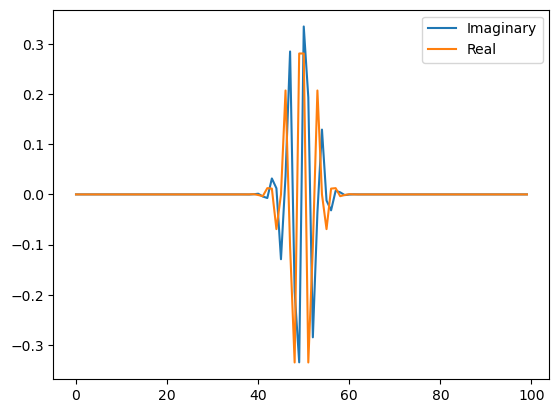

In [28]:
from scipy import signal
M = 100
w0 = 5
s = w0*90/(2*np.pi*25)
morlet_wavelet = signal.morlet2(M, s, w0)
plt.plot(morlet_wavelet.imag, label='Imaginary')
plt.plot(morlet_wavelet.real, label='Real')
plt.legend()
plt.show()

In [ ]:
wlet_feats, wlet_labels = features.wavelet(
    pc_feats, pc_labels, ids, sample_freq=90, freq=np.linspace(1, 25, 25), w0=5
)

We now use PCA to reduce the dimensions of the new wavelet features, and consolidate with the previous PC scores. Each frame is now associated with a vector of features corresponding to the PC scores of egocentric keypoint coordinates and local frequency information.

In [ ]:
# PCA on wavelet features
pc_wlet, pc_wlet_labels = features.pca(
    wlet_feats,
    wlet_labels,
    categories=["wlet_ego_euc"],
    n_pcs=5,
    method="fbpca",
)

del wlet_feats, wlet_labels
pc_feats = np.hstack((pc_feats, pc_wlet))
pc_labels += pc_wlet_labels
del pc_wlet, pc_wlet_labels

In [ ]:
# Optionally save full PC features to file
# write.features_h5(
#     pc_feats, pc_labels, path="".join([config["out_path"], "pca_feats.h5"])
# )

We encapsulate all relevant data to store in a data object.

In [ ]:
data_obj = ds.DataStruct(
    pose=pose,
    id=ids,
    meta=meta,
    meta_by_frame=meta_by_frame,
    connectivity=connectivity,
)

data_obj.features = pc_feats
# Downsampling data, appears to be necessary in order to 
# discover granular structure in embedding
data_obj = data_obj[:: config["downsample"], :]

Using t-SNE, frames are projected onto a 2D embedding for clustering and visualization.

In [ ]:
# Embedding using fitsne
embedder = Embed(
    embed_method=config["single_embed"]["method"],
    perplexity=config["single_embed"]["perplexity"],
    lr=config["single_embed"]["lr"],
)
data_obj.embed_vals = embedder.embed(data_obj.features, save_self=True)

The histogram of the 2D embedding is smoothed with a Gaussian, and segmented by the watershed algorithm to determine cluster assignments.

In [ ]:
# Watershed clustering
data_obj.ws = Watershed(
    sigma=config["single_embed"]["sigma"], max_clip=1, log_out=True, pad_factor=0.05
)
data_obj.data.loc[:, "Cluster"] = data_obj.ws.fit_predict(data=data_obj.embed_vals)

# Plot density
vis.density(
    data_obj.ws.density,
    data_obj.ws.borders,
    filepath=config["out_path"] + "/density.png",
    show=True,
)

Within the embedding, we can visualize the density of each animal separately.

In [ ]:
vis.density_cat(
    data=data_obj,
    column="id",
    watershed=data_obj.ws,
    n_col=4,
    filepath=config["out_path"] + "/density_id.png",
    show=True,
)